In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import linalg as LA
import os
import pandas as pd

In [8]:
data_loc = '../../dataset/'
decklist = os.listdir(data_loc)
filelist = os.listdir(data_loc+decklist[0]+'/')

length = len(decklist)*len(filelist)
imgary = np.zeros((length, 120*100))
labels = []
n=0
for i in decklist:
    for j in filelist:
        tmpimg = cv2.imread(data_loc+i+'/'+j, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))
        imgary[n] = tmpimg
        labels.append(j[:-4])
        n+=1

In [9]:
labels_shape =  [name[0]for name in labels]
labels_num =  [name[1:]for name in labels]

In [10]:
labels_shape_pd = pd.DataFrame(labels_shape)
labels_num_pd = pd.DataFrame(labels_num)

## 층화추출

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [12]:
for train_index, test_index in split.split(imgary, labels_shape):
    X_train_shape = imgary[train_index]
    y_train_shape = labels_shape_pd.loc[train_index]
    X_test_shape = imgary[test_index]
    y_test_shape = labels_shape_pd.loc[test_index]

In [13]:
for train_index, test_index in split.split(imgary, labels_num):
    X_train_num = imgary[train_index]
    y_train_num = labels_num_pd.loc[train_index]
    X_test_num = imgary[test_index]
    y_test_num = labels_num_pd.loc[test_index]

In [14]:
y_train_shape = np.array(y_train_shape).reshape(-1,)
y_test_shape = np.array(y_test_shape).reshape(-1,)
y_train_num = np.array(y_train_num).reshape(-1,)
y_test_num = np.array(y_test_num).reshape(-1,)

## 전처리

In [15]:
def pca(D, num=30):
    L = np.dot(D.T, D)
    w, v = LA.eig(L)


    # 고유값 0인거 제거    
    zero_eigen = [i for i in range(len(w)) if abs(w[i]) <1e-4]
    j=0
    for i in zero_eigen:
        w = np.delete(w, i-j, axis=0)
        v = np.delete(v, i-j, axis=1)
        j+=1

    # 고유값 내림차순으로 정렬
    ww = np.sort(w.real)[::-1]
    index = np.argsort(w.real)[::-1]  
    vv = np.array([v[:,i].real for i in list(index)]).T 

    ww = ww[:num]
    vv = vv[:, :num]

    u = np.dot(D, vv)
    u = u/(LA.norm(u, axis=0))

    weight=np.dot(u.T,D)
    return u, weight

In [73]:
pca_vector_shape, X_train_shape_reduced = pca(X_train_shape.T,210)
X_test_shape_reduced=np.dot(pca_vector_shape.T,X_test_shape.T)
X_train_shape_reduced = X_train_shape_reduced.T
X_test_shape_reduced = X_test_shape_reduced.T

In [74]:
from sklearn.svm import SVC
svc_shape = SVC(kernel = 'linear', C=0.6, gamma = 'auto', random_state=42)
svc_shape.fit(X_train_shape_reduced, y_train_shape)
y_pred = svc_shape.predict(X_test_shape_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846


In [75]:
from sklearn.linear_model import LogisticRegression
lr_shape = LogisticRegression(solver='liblinear', multi_class='auto', C=70.0, random_state=42)
lr_shape.fit(X_train_shape_reduced, y_train_shape)
y_pred_shape = lr_shape.predict(X_test_shape_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846


In [19]:
pca_vector_num, X_train_num_reduced = pca(X_train_num.T,100)
X_test_num_reduced=np.dot(pca_vector_num.T,X_test_num.T)
X_train_num_reduced = X_train_num_reduced.T
X_test_num_reduced = X_test_num_reduced.T

In [20]:
from sklearn.svm import SVC
svc_num = SVC(kernel = 'linear', C=2.0, gamma = 'auto', random_state=42)
svc_num.fit(X_train_num_reduced, y_train_num)
y_pred_num = svc_num.predict(X_test_num_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [21]:
from sklearn.linear_model import LogisticRegression
lr_num = LogisticRegression(solver='liblinear', multi_class='auto', C=70.0, random_state=42)
lr_num.fit(X_train_num_reduced, y_train_num)
y_pred_num = lr_num.predict(X_test_num_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


svc :  ['S'] ['10']
logistic regression :  ['S'] ['10']


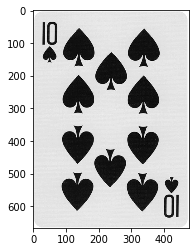

In [23]:
test_img = cv2.imread('spade10.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

['D'] ['5']
logistic regression :  ['D'] ['5']


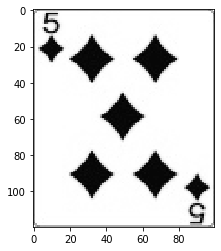

In [24]:
test_img = cv2.imread('D5.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

['H'] ['A']
logistic regression :  ['H'] ['A']


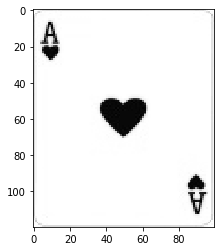

In [25]:
test_img = cv2.imread('HA.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

['S'] ['K']
logistic regression :  ['S'] ['K']


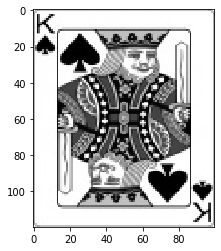

In [26]:
test_img = cv2.imread('SK.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

['H'] ['K']
logistic regression :  ['H'] ['8']


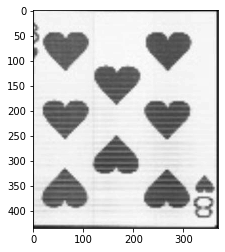

In [27]:
test_img = cv2.imread('heart8.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

## PCA 안쓰고 진행

### Shape

In [47]:
from sklearn.svm import SVC
svc_shape_raw = SVC(kernel = 'linear', C=1, gamma = 'auto', random_state=42)
svc_shape_raw.fit(X_train_shape, y_train_shape)
y_pred_shape = svc_shape_raw.predict(X_test_shape)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred_shape).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846


In [45]:
lr_shape_raw = LogisticRegression(solver='liblinear', multi_class='auto', C=100, random_state=42)
lr_shape_raw.fit(X_train_shape, y_train_shape)
y_pred_shape = lr_shape_raw.predict(X_test_shape)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred_shape).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846


## shape 틀린 것들을 확인

*****************
label : S
predict : C
*****************
label : S
predict : C
*****************
label : S
predict : D
*****************
label : S
predict : C
*****************
label : H
predict : D


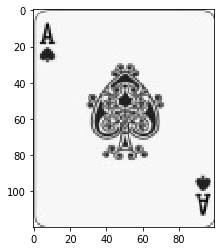

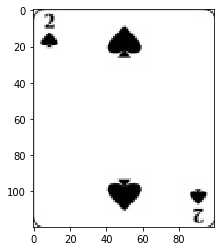

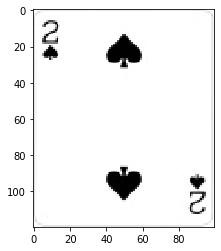

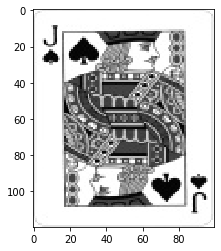

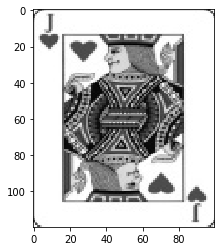

In [48]:
false_x = X_test_shape[y_test_shape !=y_pred_shape]
false_y = y_test_shape[y_test_shape !=y_pred_shape]
false_p = y_pred_shape[y_test_shape !=y_pred_shape]
for index in range(len(false_x)):
    print("*****************")
    print("label : %c" % false_y[index])
    print("predict : %c" % false_p[index])
    plt.figure()
    plt.imshow(false_x[index].reshape(120,100), cmap='gray')

### NUMBER

In [26]:
from sklearn.svm import SVC
svc_num_raw = SVC(kernel = 'linear', C=2.0, gamma = 'auto', random_state=42)
svc_num_raw.fit(X_train_num, y_train_num)
y_pred_num = svc_num_raw.predict(X_test_num)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y _test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [32]:
lr_num_raw = LogisticRegression(solver='liblinear', multi_class='auto', C=100, random_state=42)
lr_num_raw.fit(X_train_num, y_train_num)
y_pred_num = lr_num_raw.predict(X_test_num)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


## NUMBER 틀린 것들을 확인

*****************
label : Q
*****************
label : J
*****************
label : J
*****************
label : Q


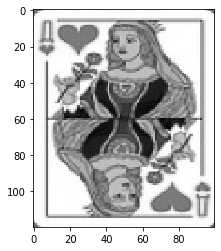

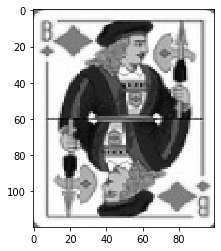

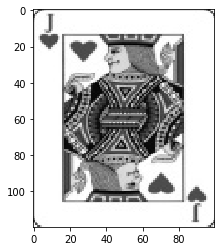

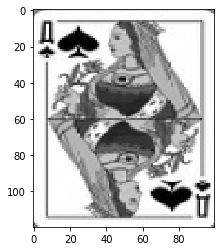

In [42]:
false_x = X_test_num[y_test_num !=y_pred_num]
false_y = y_test_num[y_test_num !=y_pred_num]
for index in range(len(false_x)):
    print("*****************")
    print("label : %c" % false_y[index])
    plt.figure()
    plt.imshow(false_x[index].reshape(120,100), cmap='gray')

In [40]:
false_x

array([[135., 134., 118., ..., 189., 125., 116.],
       [135., 133., 122., ..., 209., 138., 107.],
       [254., 255., 181., ...,  51., 196., 253.],
       [137., 137., 129., ..., 227., 148., 113.]])

In [35]:
[y_test_num !=y_pred_num]

[array([False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False])]

svc :  ['S'] ['10']
logistic regression :  ['S'] ['10']


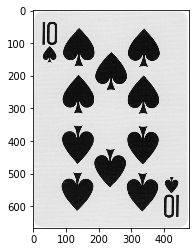

In [28]:
test_img = cv2.imread('spade10.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['D'] ['5']
logistic regression :  ['D'] ['5']


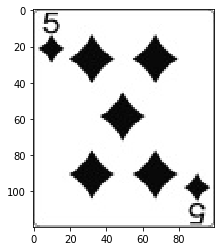

In [29]:
test_img = cv2.imread('D5.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['H'] ['A']
logistic regression :  ['H'] ['A']


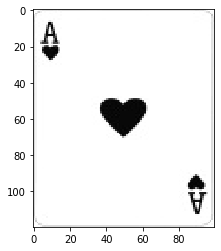

In [30]:
test_img = cv2.imread('HA.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['S'] ['K']
logistic regression :  ['S'] ['K']


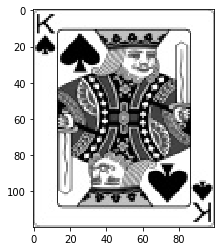

In [31]:
test_img = cv2.imread('SK.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['H'] ['K']
logistic regression :  ['H'] ['8']


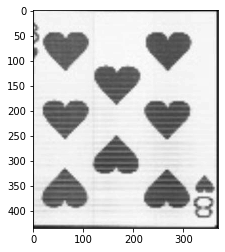

In [32]:
test_img = cv2.imread('heart8.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))